**Moduli**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# BRANJE PODATKOV

In [4]:
data_zacetno = np.load('LV balansiranje -zacetno_stanje.npy', allow_pickle=True)[()]
data_test = np.load('LV balansiranje - testno_stanje.npy', allow_pickle=True)[()]

N = data_zacetno['samples']
fs = data_zacetno['sample_rate']
dt = data_zacetno['dt']
t = np.arange(N)*dt

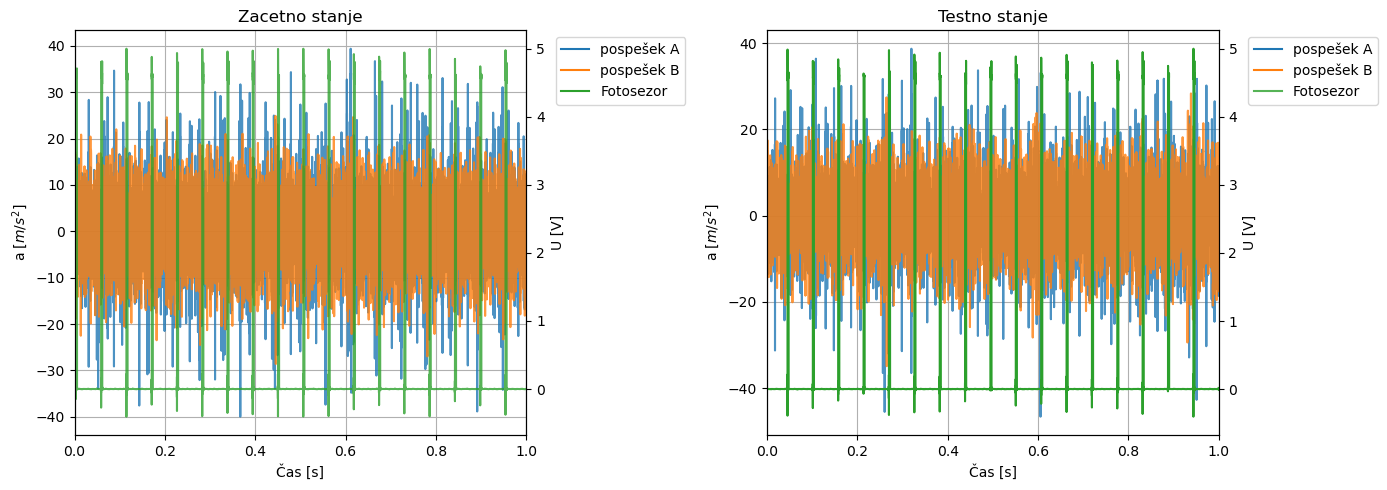

In [5]:
a0 = data_zacetno['data'][:, 0]
b0 = data_zacetno['data'][:, 1]
n0 = data_zacetno['data'][:, 2]

a1 = data_test['data'][:, 0]
b1 = data_test['data'][:, 1]
n1 = data_test['data'][:, 2]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ZACETNO STANJE
axs[0].set_title('Zacetno stanje')
axs[0].plot(t, a0, label='pospešek A', c='C0')
axs[0].plot(t, b0, label='pospešek B', c='C1')
ax_n0 = axs[0].twinx()
line_n0, = ax_n0.plot(t, n0, label='Fotosezor', c='C2')
ax_n0.set_ylabel('U [V]')
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel(r'a $[m/s^2]$')
axs[0].grid()
axs[0].set_xlim(0, 1)
lines = [line for line in axs[0].get_lines()] + [line_n0]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.9))

for line in lines:
    line.set_alpha(0.8)

# TESTNO STANJE
axs[1].set_title('Testno stanje')
axs[1].plot(t, a1, label='pospešek A', c='C0')
axs[1].plot(t, b1, label='pospešek B', c='C1')
ax_n1 = axs[1].twinx()
line_n1, = ax_n1.plot(t, n1, label='Fotosezor', c='C2')
ax_n1.set_ylabel('U [V]')
axs[1].set_xlabel('Čas [s]')
axs[1].set_ylabel(r'a $[m/s^2]$')
axs[1].grid()
axs[1].set_xlim(0, 1)
lines = [line for line in axs[1].get_lines()] + [line_n0]
labels = [line.get_label() for line in lines]
axs[1].legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.9))

for line in lines:
    line.set_alpha(0.8)

plt.tight_layout()
plt.show()


## DOLOČITEV FREKVENCE VRTENJA

In [6]:
def detect_crossing_times(time, signal, threshold=3.5):
    crossing_indices = np.where(np.logical_and(signal[:-1] < threshold, signal[1:] >= threshold))[0]
    crossing_times = time[crossing_indices]
    return crossing_times

def detect_freq(time, signal, threshold=3.5):
    crossing_times = detect_crossing_times(time, signal, threshold)
    delta_time = crossing_times[1:] - crossing_times[:-1]
    return 1/np.mean(delta_time)

f0 = detect_freq(t, n0)
f1 = detect_freq(t, n1)

ref_times_0 = detect_crossing_times(t, n0)
ref_times_1 = detect_crossing_times(t, n1)

print(f'Frekvenca vrtenja v zacetnem stanju: {f0:.2f} Hz')
print(f'Frekvenca vrtenja v testnem stanju: {f1:.2f} Hz')

Frekvenca vrtenja v zacetnem stanju: 17.88 Hz
Frekvenca vrtenja v testnem stanju: 17.81 Hz


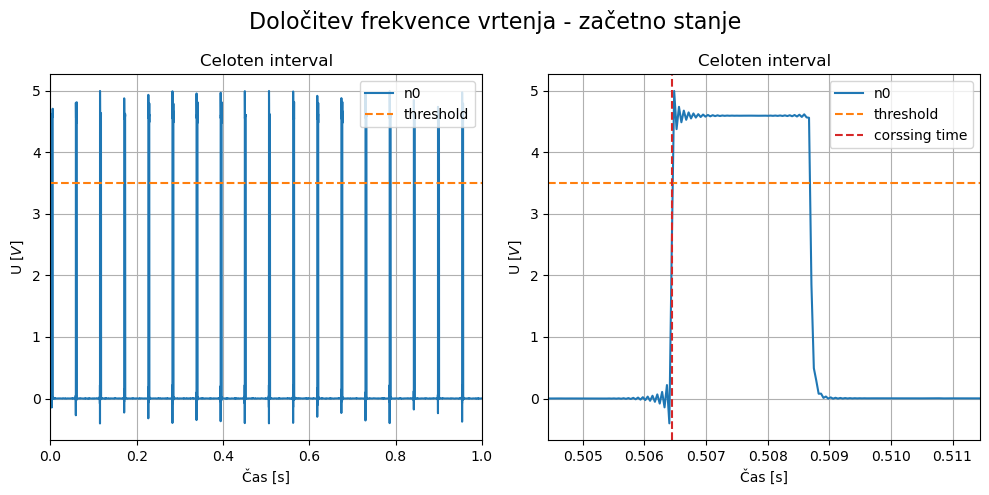

In [7]:
threshold = 3.5

zoom_time = ref_times_0[int(ref_times_0.size/2)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Določitev frekvence vrtenja - začetno stanje', fontsize=16)
# ZACETNO STANJE
axs[0].set_title('Celoten interval')
axs[0].plot(t, n0, label='n0', c='C0')
axs[0].axhline(threshold, c='C1', ls='--', label='threshold')
# x-es at posions of crossing ti
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel(r'U $[V]$')
axs[0].grid()
axs[0].set_xlim(0, 1)
axs[0].legend(loc='upper right')

# TESTNO STANJE
axs[1].set_title('Celoten interval')
axs[1].plot(t, n0, label='n0', c='C0')
axs[1].axhline(threshold, c='C1', ls='--', label='threshold')
axs[1].axvline(zoom_time, c='C3', ls='--', label='corssing time')
axs[1].set_xlabel('Čas [s]')
axs[1].set_ylabel(r'U $[V]$')
axs[1].grid()
axs[1].set_xlim(zoom_time-0.002, zoom_time+0.005)
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


## Filtriranje signalov pospeška

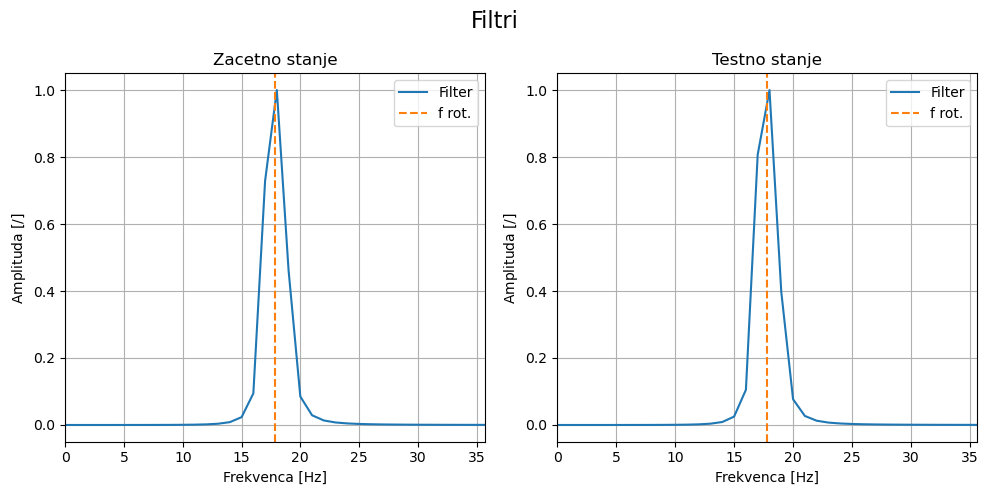

In [8]:
freq = np.fft.rfftfreq(N, dt)

order = 3
band_0 = [0.95*f0,1.05*f0]
band_1 = [0.95*f1,1.05*f1]

sos_0 = signal.butter(order, band_0, btype='band', output='sos', fs=fs)
sos_1 = signal.butter(order, band_1, btype='band', output='sos', fs=fs)
w_0, h_0 = signal.sosfreqz(sos_0, freq, fs=fs)
w_1, h_1 = signal.sosfreqz(sos_1, freq, fs=fs)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Filtri', fontsize=16)

# ZACETNO STANJE
axs[0].set_title('Zacetno stanje')
axs[0].plot(freq, np.abs(h_0), label='Filter', c='C0')
axs[0].axvline(f0, c='C1', ls='--', label='f rot.')
axs[0].set_xlabel('Frekvenca [Hz]')
axs[0].set_ylabel(r'Amplituda $[/]$')
axs[0].grid()
axs[0].set_xlim(0, 2*f0)
axs[0].legend(loc='upper right')

# TESTNO STANJE
axs[1].set_title('Testno stanje')
axs[1].plot(freq, np.abs(h_1), label='Filter', c='C0')
axs[1].axvline(f1, c='C1', ls='--', label='f rot.')
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel(r'Amplituda $[/]$')
axs[1].grid()
axs[1].set_xlim(0, 2*f1)
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

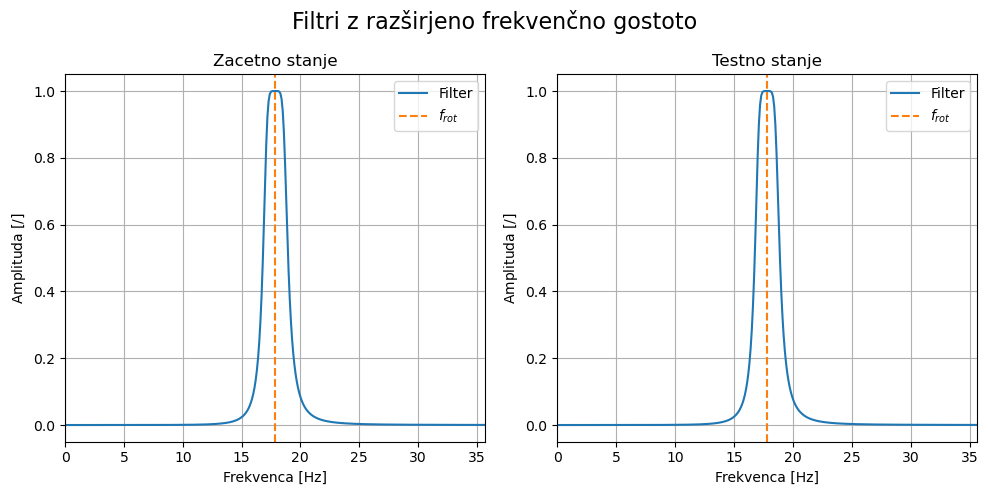

In [9]:
k = 10
freq = np.fft.rfftfreq(k*N, dt)

order = 3
band_0 = [0.95*f0,1.05*f0]
band_1 = [0.95*f1,1.05*f1]

sos_0 = signal.butter(order, band_0, btype='band', output='sos', fs=fs)
sos_1 = signal.butter(order, band_1, btype='band', output='sos', fs=fs)
w_0, h_0 = signal.sosfreqz(sos_0, freq, fs=fs)
w_1, h_1 = signal.sosfreqz(sos_1, freq, fs=fs)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Filtri z razširjeno frekvenčno gostoto', fontsize=16)

# ZACETNO STANJE
axs[0].set_title('Zacetno stanje')
axs[0].plot(freq, np.abs(h_0), label='Filter', c='C0')
axs[0].axvline(f0, c='C1', ls='--', label=r'$f_{rot}$')
axs[0].set_xlabel('Frekvenca [Hz]')
axs[0].set_ylabel(r'Amplituda $[/]$')
axs[0].grid()
axs[0].set_xlim(0, 2*f0)
axs[0].legend(loc='upper right')

# TESTNO STANJE
axs[1].set_title('Testno stanje')
axs[1].plot(freq, np.abs(h_1), label='Filter', c='C0')
axs[1].axvline(f1, c='C1', ls='--', label=r'$f_{rot}$')
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel(r'Amplituda $[/]$')
axs[1].grid()
axs[1].set_xlim(0, 2*f1)
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
A0 = np.fft.rfft(a0, n=k*N) / len(t) * 2
B0 = np.fft.rfft(b0, n=k*N) / len(t) * 2
A1 = np.fft.rfft(a1, n=k*N) / len(t) * 2
B1 = np.fft.rfft(b1, n=k*N) / len(t) * 2

A0_filtriran = A0 * h_0
B0_filtriran = B0 * h_0
A1_filtriran = A1 * h_0
B1_filtriran = B1 * h_1

a0_filtriran = np.fft.irfft(A0_filtriran) * len(t) / 2
b0_filtriran = np.fft.irfft(B0_filtriran) * len(t) / 2
a1_filtriran = np.fft.irfft(A1_filtriran) * len(t) / 2
b1_filtriran = np.fft.irfft(B1_filtriran) * len(t) / 2

In [ ]:
def sig_ref_peaks(t, a, f_aprox, N):
    peaks, _ = signal.find_peaks(a, distance=1/f_aprox*N*0.75)
    return t[peaks], a[peaks]

t_peaks_a0, a_peaks_a0 = sig_ref_peaks(t, a0_filtriran[:N], f0, N)
t_peaks_a1, a_peaks_a1 = sig_ref_peaks(t, a1_filtriran[:N], f1, N)
t_peaks_b0, a_peaks_b0 = sig_ref_peaks(t, b0_filtriran[:N], f0, N)
t_peaks_b1, a_peaks_b1 = sig_ref_peaks(t, b1_filtriran[:N], f1, N)

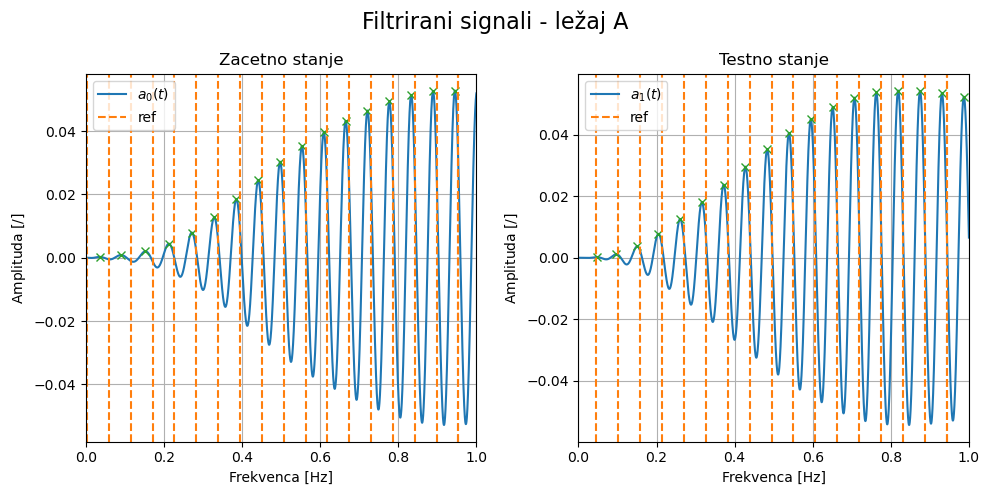

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Filtrirani signali - ležaj A', fontsize=16)

# ZACETNO STANJE
axs[0].set_title('Zacetno stanje')
axs[0].plot(t, a0_filtriran[:N], label=r'$a_0(t)$')
axs[0].plot(t_peaks_a0, a_peaks_a0, 'x', c='C2')
for ref_time in ref_times_0:
    axs[0].axvline(ref_time, c='C1', ls='--')
axs[0].axvline(ref_time, c='C1', ls='--', label='ref')
axs[0].set_xlabel('Frekvenca [Hz]')
axs[0].set_ylabel(r'Amplituda $[/]$')
axs[0].grid()
axs[0].set_xlim(0, 1)
axs[0].legend(loc='upper left')

# TESTNO STANJE
axs[1].set_title('Testno stanje')
axs[1].plot(t, a1_filtriran[:N], label=r'$a_1(t)$')
axs[1].plot(t_peaks_a1, a_peaks_a1, 'x', c='C2')
for ref_time in ref_times_1:
    axs[1].axvline(ref_time, c='C1', ls='--')
axs[1].axvline(ref_time, c='C1', ls='--', label='ref')
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel(r'Amplituda $[/]$')
axs[1].grid()
axs[1].set_xlim(0, 1)
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

## DOLOČITEV VEKTORJEV

In [ ]:
def find_avg_time_diff(ref_times, t_peaks, limits=(0.4, 0.9)):
    ref_times = ref_times[(ref_times > limits[0]) & (ref_times < limits[1])]
    time_diffs = []
    for i in ref_times:
        for j in t_peaks:
            if j > i:
                time_diffs.append(j-i)
                break
    return np.mean(time_diffs)

delta_t_a0 = find_avg_time_diff(ref_times_0, t_peaks_a0)
delta_t_a1 = find_avg_time_diff(ref_times_1, t_peaks_a1)
delta_t_b0 = find_avg_time_diff(ref_times_0, t_peaks_b0)
delta_t_b1 = find_avg_time_diff(ref_times_1, t_peaks_b1)

phi_a0 = delta_t_a0 * f0 * 2 * np.pi
phi_a1 = delta_t_a1 * f1 * 2 * np.pi
phi_b0 = delta_t_b0 * f0 * 2 * np.pi
phi_b1 = delta_t_b1 * f1 * 2 * np.pi

max_a0 = np.max(a0_filtriran)
max_a1 = np.max(a1_filtriran)
max_b0 = np.max(b0_filtriran)
max_b1 = np.max(b1_filtriran)

## DOLOČITEV KOREKCIJSKE MASE

In [ ]:
def balansiranje(Au, Auw, PHI, phi, mt):
    Aw = np.sqrt(Au**2 + Auw**2 - 2*Au*Auw*np.cos(phi-PHI))
    buff = (Au**2+Aw**2-Auw**2)/(2*Au*Aw)
    phi_new = np.arccos(buff)
    return Au/Aw*mt, phi_new*180/np.pi, Aw, phi_new

In [ ]:
m_t = 2.8

m_a, phi_a, Aw_a, phi_w_a = balansiranje(max_a0, max_a1, phi_a0, phi_a1, m_t)
m_b, phi_b, Aw_b, phi_w_b = balansiranje(max_b0, max_b1, phi_b0, phi_b1, m_t)

In [ ]:
print(f'Korekcijska masa (glede na ležaj A): {m_a:.2f} g na poziciji {phi_a:.2f}°')
print(f'Korekcijska masa (glede na ležaj B): {m_b:.2f} g na poziciji {phi_b:.2f}°')
print(f'Korekcijska masa (povprečje): {(m_a+m_b)/2:.2f} g na poziciji {(phi_a+phi_b)/2:.2f}°')

Korekcijska masa (glede na ležaj A): 8.16 g na poziciji 85.45°
Korekcijska masa (glede na ležaj B): 8.13 g na poziciji 69.23°
Korekcijska masa (povprečje): 8.14 g na poziciji 77.34°


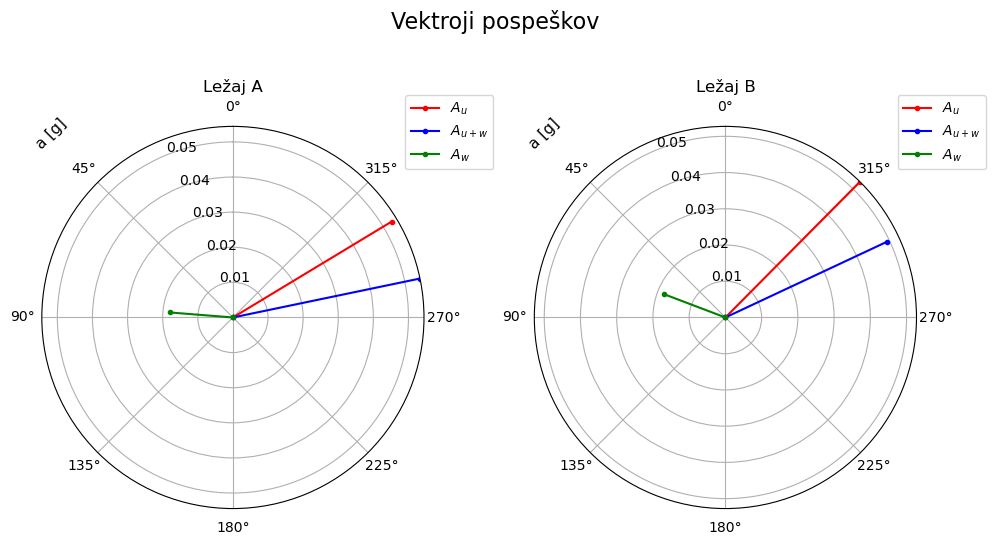

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': 'polar'})
fig.suptitle('Vektroji pospeškov', fontsize=16)

ax[0].set_title('Ležaj A')
ax[0].plot([phi_a0, phi_a0], [0, max_a0], '.-', color='red', label=r'$A_{u}$')
ax[0].plot([phi_a1, phi_a1], [0, max_a1], '.-', color='blue', label=r'$A_{u+w}$')
ax[0].plot([phi_w_a, phi_w_a], [0, Aw_a], '.-', color='green', label=r'$A_{w}$')
ax[0].set_ylim([0, max(max_a0, max_a1, Aw_a)])
ax[0].grid(True)
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
ax[0].set_theta_zero_location('N')
ax[0].set_ylabel('a [g]', rotation=45, size=11, loc='top', labelpad=-20)

ax[1].set_title('Ležaj B')
ax[1].plot([phi_b0, phi_b0], [0, max_b0], '.-', color='red', label=r'$A_{u}$')
ax[1].plot([phi_b1, phi_b1], [0, max_b1], '.-', color='blue', label=r'$A_{u+w}$')
ax[1].plot([phi_w_b, phi_w_b], [0, Aw_b], '.-', color='green', label=r'$A_{w}$')
ax[1].set_ylim([0, max(max_b0, max_b1, Aw_b)])
ax[1].grid(True)
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
ax[1].set_theta_zero_location('N')
ax[1].set_ylabel('a [g]', rotation=45, size=11, loc='top', labelpad=-20)

plt.tight_layout()
plt.show()
